In [1]:
library(ggplot2)
library(ggpubr)
library(aod)
library(ROCR)
library(survival)
library(survminer)


Attaching package: ‘survival’


The following object is masked from ‘package:aod’:

    rats




In [2]:
options(jupyter.plot_mimetypes = "image/png", dpi = 300)
options(repr.plot.width = 5, repr.plot.height = 5)

In [3]:
pheno <- read.csv('/mnt/stsi/stsi1/sfchen/191120_PRS_validator/analysis/aric_cad_pheno.csv')
pheno$ID <- as.character(pheno$SAMPLE_ID)
pheno$N <- length(pheno$ID)
data <- pheno[,c('ID','N','ISP12','AGISP12')]


file <- read.csv('exBTs_regenie_phenoCol1_SPA_CADComp.regenie.reweighted-PRS_2865113-aric_c1-ancestry_1-N_8264-chrALL.csv')
file <- rbind(file,read.csv('exBTs_regenie_phenoCol1_SPA_CADComp.regenie.reweighted-PRS_2865113-aric_c1-ancestry_3-N_3-chrALL.csv'))
file <- rbind(file,read.csv('exBTs_regenie_phenoCol1_SPA_CADComp.regenie.reweighted-PRS_2865113-aric_c1-ancestry_5-N_508-chrALL.csv'))
file <- rbind(file,read.csv('exBTs_regenie_phenoCol1_SPA_CADComp.regenie.reweighted-PRS_2865113-aric_c1-ancestry_mixed-N_4284-chrALL.csv'))
file$ID <- sapply(strsplit(file$X.sampleID,'_'),'[[',2)
file$PRS <- file$sum_PRS / file$SNP_N
file <- file[,c('ID','PRS')]
data <- merge(data,file,by='ID')


data$ISP12 <- as.factor(data$ISP12)

In [4]:
data$PRS_std <- ( ( data[['PRS']] - mean(data[['PRS']] )) / sd(data[['PRS']]) )

In [5]:
plot <- ggplot(data, aes_string('PRS_std', color = 'ISP12')) + 
geom_vline(xintercept = 0, linetype = 'longdash') +
geom_vline(xintercept = mean(data[data$ISP12==0,'PRS_std']), linetype = 'longdash', color = '#F8766D') +
geom_vline(xintercept = mean(data[data$ISP12==1,'PRS_std']), linetype = 'longdash', color = '#00BFC4') +
geom_density(color = 'black') + 
geom_density() + 
theme_classic()

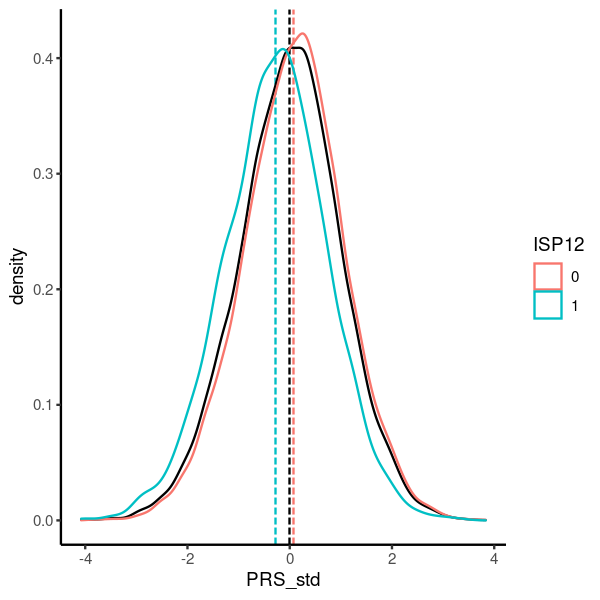

In [6]:
plot
ggsave('PRS_Plot.png', 
       device = 'png', 
       width = 5, 
       height = 5, 
       units = "in", 
       path = '~/Torkamani_Projects/20210712_Analysis-RegeniePaper/CAD_PRS/SCT/PRS_Calculated/')

In [7]:
logit <- glm(formula(paste0("ISP12 ~", 'PRS_std')), data = data, family = binomial)
summary <- summary(logit)
coeff <- summary$coefficients[2,1]
error <- summary$coefficients[2,2]


In [8]:
logit_results <- data.frame('PRS_std',exp(as.numeric(coeff)), exp(as.numeric(coeff)) * as.numeric(error))
names(logit_results) <- c('PRS_Score','Log_Odds','Error')

In [9]:
plot <- ggplot(logit_results, aes(x = PRS_Score, y = Log_Odds)) + 
geom_point() + 
geom_errorbar(aes(ymin=Log_Odds-(1.96*Error), ymax=Log_Odds+(1.96*Error)), width=.5) +
theme_classic()

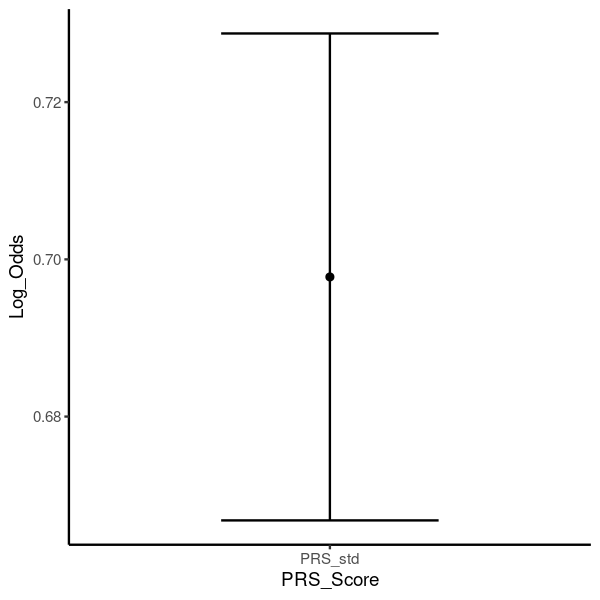

In [10]:
plot
ggsave('Log_Odds_Plot.png', 
       device = 'png', 
       width = 5, 
       height = 5, 
       units = "in", 
       path = '~/Torkamani_Projects/20210712_Analysis-RegeniePaper/CAD_PRS/SCT/PRS_Calculated/')

In [11]:
logit_results[logit_results$Log_Odds == max(logit_results$Log_Odds),]

,PRS_Score,Log_Odds,Error
,<chr>,<dbl>,<dbl>
1,PRS_std,0.6977628,0.01580147


In [12]:
pred <- prediction(data[['PRS_std']],data$ISP12)
perf <- performance(pred,"sens","spec")

perf_data <- data.frame(slot(perf,'x.values'), slot(perf,'y.values'))
names(perf_data) <- c('Specificity','Sensitivity')

plot <- ggplot(perf_data, aes(x = Specificity, y = Sensitivity)) + 
geom_line() +
ggtitle('ROC Curve') +
geom_text(x = 0.4, y = 0.4, label = paste('AUC = ',performance(pred, measure = "auc")@y.values[[1]])) +
coord_cartesian(xlim = c(1,0)) +
theme_classic()

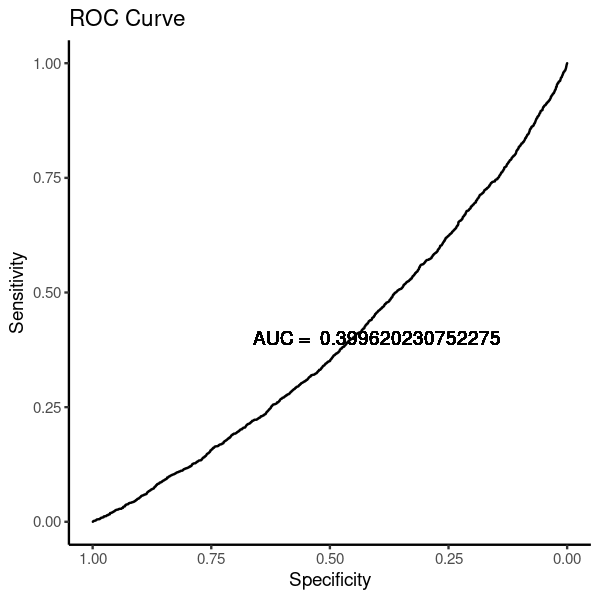

In [13]:
plot

ggsave('ROC_Plots.png',
       device = 'png', 
       width = 5, 
       height = 5, 
       units = "in", 
       path = '~/Torkamani_Projects/20210712_Analysis-RegeniePaper/CAD_PRS/SCT/PRS_Calculated/')

In [14]:
data['cutoff'] <- as.factor(data['PRS_std'] > 0.842)

In [15]:
head(data)

,ID,N,ISP12,AGISP12,PRS,PRS_std,cutoff
,<chr>,<int>,<fct>,<int>,<dbl>,<dbl>,<fct>
1,100047,40120,0,70,0.0001035280,0.9801899,TRUE
2,100056,40120,0,81,0.0001034705,0.5873026,FALSE
3,100104,40120,0,70,0.0001033226,-0.4236474,FALSE
4,100108,40120,0,77,0.0001034379,0.3646183,FALSE
5,100193,40120,0,74,0.0001035154,0.8935709,TRUE
6,100201,40120,0,77,0.0001037326,2.3781329,TRUE


In [16]:
data$ISP12 <- as.integer(data$ISP12)
res.cox <- coxph(Surv(AGISP12, ISP12) ~ cutoff, data = data)
summary(res.cox)

Call:
coxph(formula = Surv(AGISP12, ISP12) ~ cutoff, data = data)

  n= 12153, number of events= 2610 

               coef exp(coef) se(coef)      z Pr(>|z|)    
cutoffTRUE -0.59660   0.55068  0.05883 -10.14   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
cutoffTRUE    0.5507      1.816    0.4907     0.618

Concordance= 0.545  (se = 0.003 )
Likelihood ratio test= 119  on 1 df,   p=<2e-16
Wald test            = 102.8  on 1 df,   p=<2e-16
Score (logrank) test = 105.9  on 1 df,   p=<2e-16


In [17]:
plot <- ggsurvplot(survfit(Surv(AGISP12, ISP12) ~ cutoff, data = data), data = data, fun = "event")

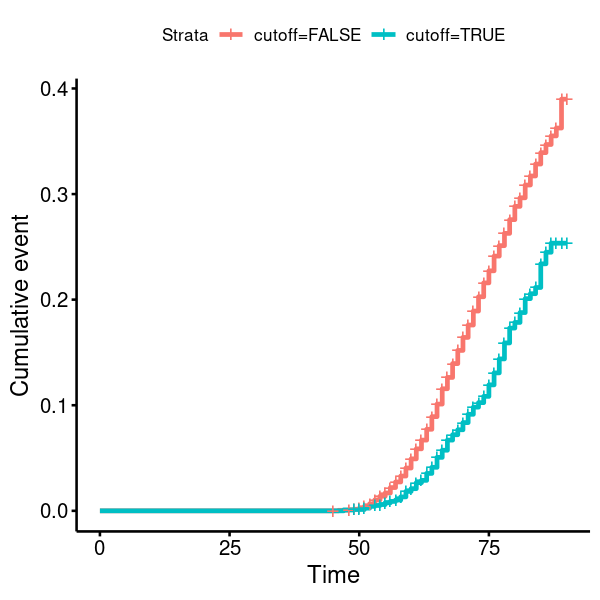

In [18]:
plot
ggsave('Cumulative_Risk_Plots.png',
       device = 'png', 
       width = 5, 
       height = 5, 
       units = "in", 
       path = '~/Torkamani_Projects/20210712_Analysis-RegeniePaper/CAD_PRS/SCT/PRS_Calculated/')